# Basic regression: Predict fuel efficiency

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [1]:
# Use seaborn for pairplot.
#!pip install -q ipympl

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp

print(tf.__version__)

2.9.1


In [4]:
%reload_ext tensorboard

### Get the data
First download and import the dataset using pandas:

In [5]:
# load the og dataset
url = './fake_data_skewed.csv'
raw_dataset = pd.read_csv(url, na_values='?', skipinitialspace=True)

In [6]:
# look at the dataset
dataset = raw_dataset.copy()
print(dataset)

        li          si       lo          so  ao        po
0      0.0   35.000000   78.112   67.640500  12  3.343378
1      0.0   49.210526   78.112   82.608447  10  3.330189
2      0.0   63.421053   78.112   97.576395   9  3.318366
3      0.0   77.631579   78.112  112.544342   8  3.307956
4      0.0   91.842105   78.112  127.512289   7  3.299003
..     ...         ...      ...         ...  ..       ...
395  205.0  248.157895  281.636  292.159711 -16  2.761745
396  205.0  262.368421  281.636  307.127658 -18  2.782096
397  205.0  276.578947  281.636  322.095605 -20  2.804706
398  205.0  290.789474  281.636  337.063553 -22  2.829293
399  205.0  305.000000  281.636  352.031500 -24  2.855600

[400 rows x 6 columns]


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of parameters from the training set.

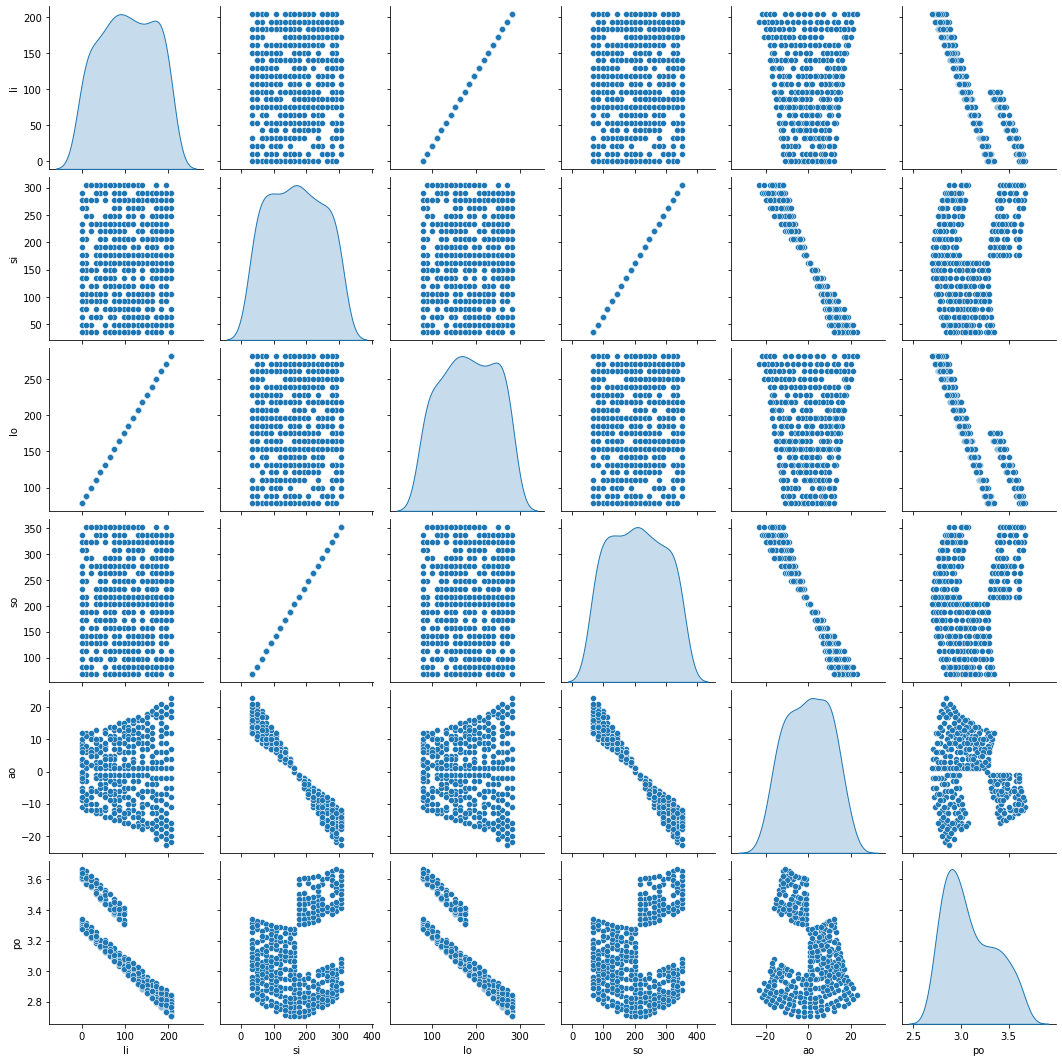

In [8]:
sns.pairplot(train_dataset[['li', 'si', 'lo', 'so','ao','po']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [9]:
train_dataset.describe()

,li,si,lo,so,ao,po
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,105.062500,167.513158,182.418050,207.216609,-0.021875,3.094635
std,62.054214,81.568094,61.607424,85.915673,10.553468,0.260821
min,0.000000,35.000000,78.112000,67.640500,-23.000000,2.703322
25%,53.947368,91.842105,131.670947,127.512289,-9.000000,2.878891
50%,107.894737,162.894737,185.229895,202.352026,1.000000,3.025096
75%,161.842105,233.947368,238.788842,277.191763,9.000000,3.302795
max,205.000000,305.000000,281.636000,352.031500,23.000000,3.670170


In [10]:
test_dataset.describe()

,li,si,lo,so,ao,po
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,92.250000,179.947368,169.697800,220.313563,-1.200000,3.157950
std,62.581773,83.701895,62.131184,88.163206,10.630027,0.284550
min,0.000000,35.000000,78.112000,67.640500,-24.000000,2.722826
25%,32.368421,106.052632,110.247368,142.480237,-10.000000,2.916103
50%,86.315789,191.315789,163.806316,232.287921,-3.500000,3.101299
75%,151.052632,251.710526,228.077053,295.901697,8.000000,3.471969
max,205.000000,305.000000,281.636000,352.031500,22.000000,3.685398


In [11]:
train_dataset

,li,si,lo,so,ao,po
94,43.157895,233.947368,120.959158,277.191763,-7,3.494272
32,10.789474,205.526316,88.823789,247.255868,-3,3.578500
225,118.684211,106.052632,195.941684,142.480237,8,2.966276
157,75.526316,276.578947,153.094526,322.095605,-12,3.436879
356,183.421053,262.368421,260.212421,307.127658,-16,2.833884
...,...,...,...,...,...,...
224,118.684211,91.842105,195.941684,127.512289,10,2.977250
355,183.421053,248.157895,260.212421,292.159711,-14,2.815527
229,118.684211,162.894737,195.941684,202.352026,1,2.944962
308,161.842105,148.684211,238.788842,187.384079,3,2.826350


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset[['li','si']].copy()
train_labels = train_dataset[['lo','so','ao','po']].copy()

In [13]:
test_features = test_dataset[['li','si']].copy()
test_labels = test_dataset[['lo','so','ao','po']].copy()

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
li,105.062500,62.054214
si,167.513158,81.568094
lo,182.418050,61.607424
so,207.216609,85.915673
ao,-0.021875,10.553468
po,3.094635,0.260821


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [16]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [17]:
print(normalizer.mean.numpy())

[[105.062 167.513]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:10])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 43.16 233.95]
 [ 10.79 205.53]
 [118.68 106.05]
 [ 75.53 276.58]
 [183.42 262.37]
 [ 10.79 106.05]
 [ 32.37 134.47]
 [ 97.11 162.89]
 [161.84  91.84]
 [118.68 120.26]]

Normalized: [[-1.    0.82]
 [-1.52  0.47]
 [ 0.22 -0.75]
 [-0.48  1.34]
 [ 1.26  1.16]
 [-1.52 -0.75]
 [-1.17 -0.41]
 [-0.13 -0.06]
 [ 0.92 -0.93]
 [ 0.22 -0.58]]


## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [19]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([8, 16, 32]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([2, 3, 4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
OBJECTIVES = hp.HParam('objective', hp.Discrete(['lo', 'so', 'ao', 'po']))

METRIC_ACCURACY = 'loss'
MAX_DEVIATION = 'Maximum deviation'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, OBJECTIVES, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Loss'), hp.Metric(MAX_DEVIATION, display_name='Maximum deviation')],
    )
    
def build_and_train_model(norm, hparams, train_features, train_labels, test_features, test_labels):
    model = keras.Sequential([norm])

    for i in range(hparams[HP_NUM_LAYERS]):
        model.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))

    model.add(layers.Dense(1))
    model.compile(loss='mean_absolute_error',
                  optimizer=hparams[HP_OPTIMIZER])
    model.fit(
        train_features,
        train_labels,
        verbose=0,
        validation_split=0.2,
        epochs=500)
    
    test_predictions = model.predict(test_features).flatten()
    error = (test_predictions - test_labels).abs()
    print('MAE: ', error.mean())
    print('M(ax)AE: ', error.max())
    
    return error.mean(), error.max()


In [20]:
def run(run_dir, hparams, train_features, train_labels, test_features, test_labels):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        loss, max_dev = build_and_train_model(normalizer, 
                                         hparams, 
                                         train_features, train_labels, test_features, test_labels)
        tf.summary.scalar(METRIC_ACCURACY, loss, step=1)
        tf.summary.scalar(MAX_DEVIATION, max_dev, step=1)

In [21]:
session_num = 0
for objective in OBJECTIVES.domain.values:
    for num_units in HP_NUM_UNITS.domain.values:
        for num_layers in HP_NUM_LAYERS.domain.values:
            for optimizer in HP_OPTIMIZER.domain.values:
                hparams = {
                    OBJECTIVES: objective,
                    HP_NUM_UNITS: num_units,
                    HP_NUM_LAYERS: num_layers,
                    HP_OPTIMIZER: optimizer,
                }
                run_name = "run-%s-%d" %(objective, session_num)
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, 
                    hparams, 
                    train_features, train_labels[objective], 
                    test_features, test_labels[objective])
                session_num += 1


--- Starting trial: run-ao-0
{'objective': 'ao', 'num_units': 8, 'num_layers': 2, 'optimizer': 'adam'}
3/3 [==============================] - 0s 2ms/step
MAE:  0.47912232056260107
M(ax)AE:  2.9968814849853516
--- Starting trial: run-ao-1
{'objective': 'ao', 'num_units': 8, 'num_layers': 3, 'optimizer': 'adam'}
3/3 [==============================] - 0s 2ms/step
MAE:  0.3698699057102203
M(ax)AE:  0.9297146797180176
--- Starting trial: run-ao-2
{'objective': 'ao', 'num_units': 8, 'num_layers': 4, 'optimizer': 'adam'}
3/3 [==============================] - 0s 3ms/step
MAE:  0.3525725036859512
M(ax)AE:  0.9844479560852051
--- Starting trial: run-ao-3
{'objective': 'ao', 'num_units': 16, 'num_layers': 2, 'optimizer': 'adam'}
3/3 [==============================] - 0s 3ms/step
MAE:  0.32384088039398196
M(ax)AE:  0.9008197784423828
--- Starting trial: run-ao-4
{'objective': 'ao', 'num_units': 16, 'num_layers': 3, 'optimizer': 'adam'}
3/3 [==============================] - 0s 3ms/step
MAE:  0.29

3/3 [==============================] - 0s 2ms/step
MAE:  0.25922977977550554
M(ax)AE:  1.4600480153937525
--- Starting trial: run-so-33
{'objective': 'so', 'num_units': 32, 'num_layers': 2, 'optimizer': 'adam'}
3/3 [==============================] - 0s 2ms/step
MAE:  0.03232635401687176
M(ax)AE:  0.12088305664062204
--- Starting trial: run-so-34
{'objective': 'so', 'num_units': 32, 'num_layers': 3, 'optimizer': 'adam'}
3/3 [==============================] - 0s 2ms/step
MAE:  0.08387236191586141
M(ax)AE:  0.27842860492927457
--- Starting trial: run-so-35
{'objective': 'so', 'num_units': 32, 'num_layers': 4, 'optimizer': 'adam'}
3/3 [==============================] - 0s 4ms/step
MAE:  0.27721832211146735
M(ax)AE:  0.9198244628906309


In [22]:
%tensorboard --logdir logs/hparam_tuning --host localhost

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib notebook

In [56]:
hparams = { OBJECTIVES: 'ao',
            HP_NUM_UNITS: 32,
            HP_NUM_LAYERS: 2,
            HP_OPTIMIZER: 'adam',
            }

dnn_model = keras.Sequential([normalizer])

for i in range(hparams[HP_NUM_LAYERS]):
    dnn_model.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))

dnn_model.add(layers.Dense(1))
dnn_model.compile(loss='mean_absolute_error',
              optimizer=hparams[HP_OPTIMIZER])
dnn_model.fit(
    train_features,
    train_labels[hparams[OBJECTIVES]],
    verbose=0,
    validation_split=0.2,
    epochs=500)

dnn_model.evaluate(test_features, test_labels[hparams[OBJECTIVES]])

3/3 [==============================] - 0s 2ms/step - loss: 0.2938


0.29383713006973267

In [57]:
x = np.linspace(0, 205, 30)
y = np.linspace(35, 305, 30)
X, Y = np.meshgrid(x, y)

In [58]:
demonstration_features = pd.DataFrame(data={
    'li': X.flatten(),
    'si': Y.flatten()
                         }
                                     )
demonstration_labels = dnn_model.predict(demonstration_features)

29/29 [==============================] - 0s 2ms/step


<IPython.core.display.Javascript object>


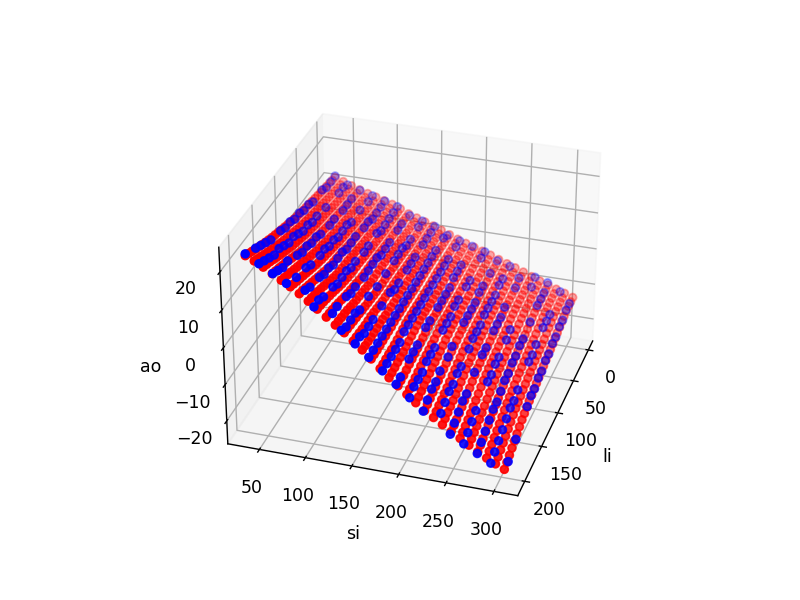

In [59]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('li')
ax.set_ylabel('si')
ax.set_zlabel(hparams[OBJECTIVES])

# Data for three-dimensional scattered points
zdata = train_labels[hparams[OBJECTIVES]]
xdata = train_features['li']
ydata = train_features['si']
ax.scatter3D(xdata, ydata, zdata, color='blue');

pred_zdata = demonstration_labels
pred_xdata = demonstration_features['li']
pred_ydata = demonstration_features['si']

ax.scatter3D(pred_xdata, pred_ydata, pred_zdata, color='red', cmap='plasma');
plt.savefig('./images/'+ hparams[OBJECTIVES] + 
            '-pred-' + str(hparams[HP_NUM_UNITS]) +
            '-' + str(hparams[HP_NUM_LAYERS])+ 
            '.png')